In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


In [2]:
data=pd.read_csv('../data/external/Shakespeare_data.csv')

# Exploratory Data Analysis

In [3]:
data.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111396 entries, 0 to 111395
Data columns (total 6 columns):
Dataline            111396 non-null int64
Play                111396 non-null object
PlayerLinenumber    111393 non-null float64
ActSceneLine        105153 non-null object
Player              111389 non-null object
PlayerLine          111396 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB


In [5]:
data["Player"].fillna("Other", inplace = True)
data.shape

(111396, 6)

In [6]:
data=data.dropna()
data.reset_index(drop=True, inplace=True)
data.shape

(105153, 6)

 ### Number of lines each player has in a play

In [7]:
data.groupby(['Play', 'Player']).count()['Dataline']

Play                      Player            
A Comedy of Errors        ADRIANA               276
                          AEGEON                147
                          AEMELIA                73
                          ANGELO                 96
                          ANTIPHOLUS              6
                          BALTHAZAR              31
                          Courtezan              40
                          DROMIO OF EPHESUS     187
                          DROMIO OF SYRACUSE    314
                          DUKE SOLINUS           93
                          First Merchant         18
                          Gaoler                  1
                          LUCE                   11
                          LUCIANA               108
                          OF EPHESUS            210
                          OF SYRACUSE           271
                          Officer                16
                          PINCH                  16
                   

### Number of players in each play

In [8]:
numberofPlayers = data.groupby(['Play'])['Player'].nunique().sort_values(ascending= False).to_frame()
numberofPlayers['Play'] = numberofPlayers.index.tolist()
numberofPlayers.columns = ['Number of Players','Play']
numberofPlayers.index= np.arange(0,len(numberofPlayers))
numberofPlayers

,Number of Players,Play
0,70,Richard III
1,65,Henry VI Part 2
2,61,Coriolanus
3,55,Timon of Athens
4,54,Antony and Cleopatra
5,52,Henry VI Part 1
6,50,Julius Caesar
7,48,Pericles
8,47,Henry V
9,47,Henry VIII


### No of players in each play - Plot

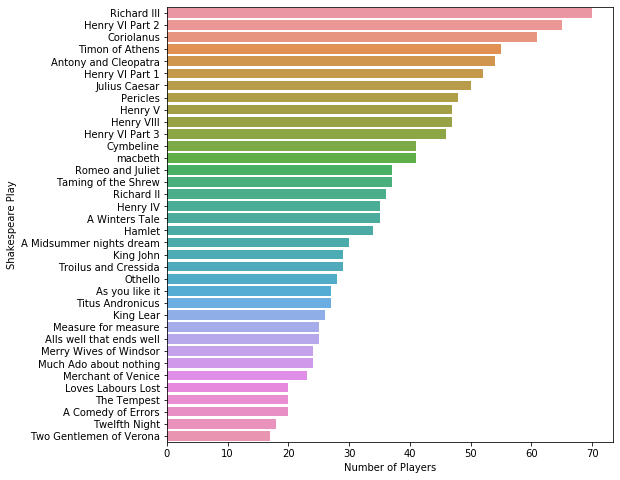

In [9]:
plt.figure(figsize=(8,8))
ax = sns.barplot(x='Number of Players',y='Play',data=numberofPlayers)
ax.set(xlabel='Number of Players', ylabel='Shakespeare Play')
plt.show()

### # of dialogues per each player

In [10]:
numberoflines = data.groupby(['Player'])['PlayerLine'].nunique().sort_values(ascending= False).to_frame()
numberoflines['Player'] = numberoflines.index.tolist()
numberoflines.columns = ['Number of lines','Player']
numberoflines.index= np.arange(0,len(numberoflines))
numberoflines.sample(10)


,Number of lines,Player
575,20,GREGORY
856,2,First Apparition
146,233,DEMETRIUS
766,5,Scout
385,56,Second Servant
227,157,SIMONIDES
355,67,Painter
307,91,First Clown
710,8,CHRISTOPHER
770,5,CURIO


## # of dialogues per each player-Plot

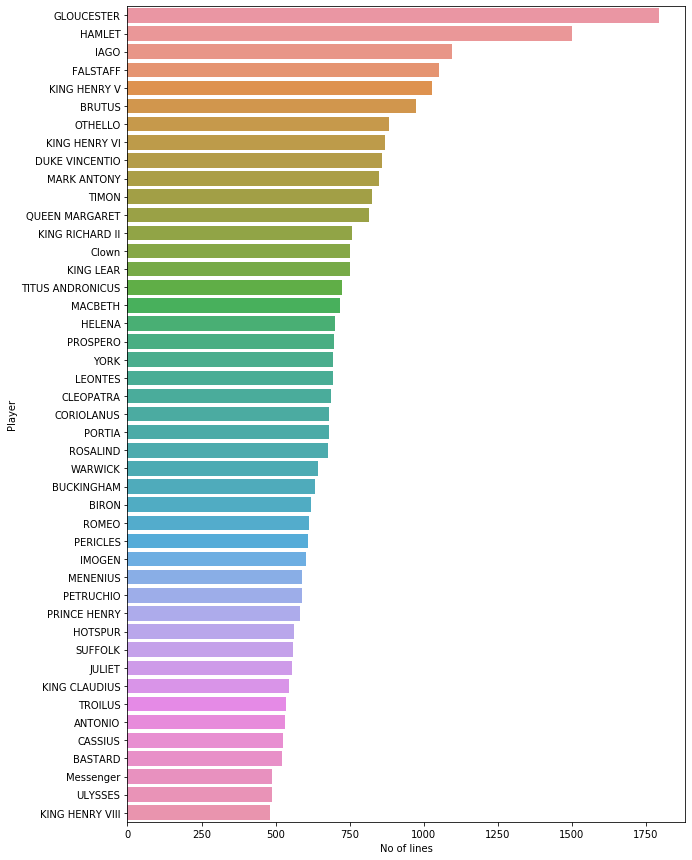

In [11]:
plt.figure(figsize=(10,15))
ax = sns.barplot(x='Number of lines',y='Player',data=numberoflines.head(45))
ax.set(xlabel='No of lines', ylabel='Player')
plt.show()

# Feature Engineering

In [12]:
df1 = pd.DataFrame(data, columns = ['ActSceneLine','Play'])
df1.sample(5)


,ActSceneLine,Play
85474,4.2.84,Taming of the Shrew
104095,4.4.508,A Winters Tale
29952,5.4.194,Cymbeline
44872,3.1.17,Julius Caesar
70232,3.4.193,Othello


### Splitting the ActSceneLine in to three different columns

In [13]:

dataExpanded = data['ActSceneLine'].str.split('.', expand=True)
data['Act'] = dataExpanded[0]
data['Scene'] = dataExpanded[1]
data['SceneLine'] = dataExpanded[2]
data=data.drop(columns=['ActSceneLine'])
data.head()

,Dataline,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,SceneLine
0,4,Henry IV,1.0,KING HENRY IV,"So shaken as we are, so wan with care,",1,1,1
1,5,Henry IV,1.0,KING HENRY IV,"Find we a time for frighted peace to pant,",1,1,2
2,6,Henry IV,1.0,KING HENRY IV,And breathe short-winded accents of new broils,1,1,3
3,7,Henry IV,1.0,KING HENRY IV,To be commenced in strands afar remote.,1,1,4
4,8,Henry IV,1.0,KING HENRY IV,No more the thirsty entrance of this soil,1,1,5


In [14]:
numberofActs=data.groupby(['Player']).max()['Act'].sort_values(ascending= False).to_frame()
numberofActs['Player'] = numberofActs.index.tolist()
numberofActs.columns = ['Number of Acts','Player']
numberofActs.index= np.arange(0,len(numberofActs))
numberofActs.sample(10)
data.dtypes
numberofActs['Number of Acts'] = numberofActs['Number of Acts'].astype(int)




### Number of acts for each player

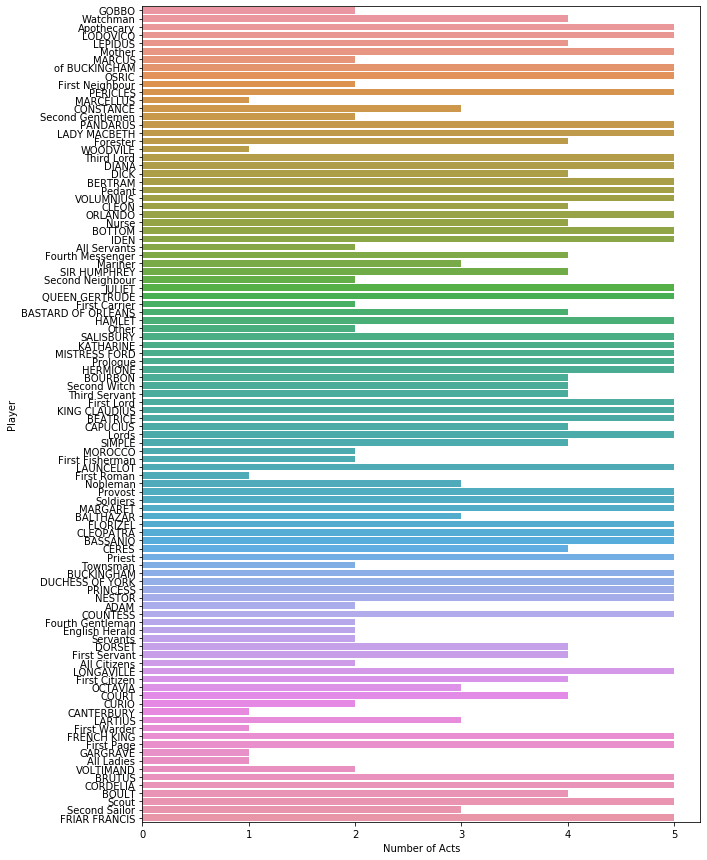

In [15]:
plt.figure(figsize=(10,15))
ax = sns.barplot(x='Number of Acts',y='Player',data=numberofActs.sample(100))
ax.set(xlabel='Number of Acts', ylabel='Player')
plt.show()

# Word vectorization

### Removing the punctuation marks in the player lines

In [16]:
data['PlayerLine'] = data['PlayerLine'].str.lower()
punctuation_marks = list("?:!.,;")
for punct_mark in punctuation_marks:
    data['PlayerLine'] = data['PlayerLine'].str.replace(punct_mark, '')

In [17]:
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')
print("------------------------------------------------------------")
nltk.download('stopwords')

------------------------------------------------------------
------------------------------------------------------------


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sahithireddypaspuleti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sahithireddypaspuleti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sahithireddypaspuleti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Lemmatization of words

In [18]:
wordnet_lemmatizer = WordNetLemmatizer()
numberofplayerLines = len(data)
lemmatized_text_list = []

for row in range(0, numberofplayerLines):
    lemmatized_word_list = []
    dialogue = data.loc[row]['PlayerLine']
    dialogue_words = dialogue.split(" ")
    for word in dialogue_words:
        lemmatized_word_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    lemmatized_text = " ".join(lemmatized_word_list)
    lemmatized_text_list.append(lemmatized_text)

In [19]:
data['PlayerLine'] = lemmatized_text_list
data.head()

,Dataline,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,SceneLine
0,4,Henry IV,1.0,KING HENRY IV,so shake as we be so wan with care,1,1,1
1,5,Henry IV,1.0,KING HENRY IV,find we a time for fright peace to pant,1,1,2
2,6,Henry IV,1.0,KING HENRY IV,and breathe short-winded accent of new broil,1,1,3
3,7,Henry IV,1.0,KING HENRY IV,to be commence in strand afar remote,1,1,4
4,8,Henry IV,1.0,KING HENRY IV,no more the thirsty entrance of this soil,1,1,5


In [20]:
stop_words = list(stopwords.words('english'))
for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    data['PlayerLine'] = data['PlayerLine'].str.replace(regex_stopword, '')
data['Word_tokens']=data['PlayerLine'].apply(lambda x:' '.join(w for w in nltk.word_tokenize(x.lower().strip()) if not w in stop_word) )
data.Word_tokens.head()

0                           shake wan care
1              find time fright peace pant
2    breathe short-winded accent new broil
3              commence strand afar remote
4                    thirsty entrance soil
Name: Word_tokens, dtype: object

### Word Tokenization

In [21]:
data_play_content=pd.DataFrame(data.groupby('Player')['Word_tokens'].apply(lambda x: "{%s}" % ', '.join(x)))
data_play_content.head(10)

,Word_tokens
Player,
A Lord,{sir}
A Patrician,"{man marr fortune, nobler, ay burn}"
A Player,"{please lordship accept duty, think was soto h..."
AARON,"{climbeth tamora olympus top, safe fortune sho..."
ABERGAVENNY,"{can not tell, heaven hath give -- let graver ..."
ABHORSON,"{call sir, bawd sir fie upon discredit mystery..."
ABRAHAM,"{bite thumb us sir, bite thumb us sir, quarrel..."
ACHILLES,"{ajax wherefore thus, thersites matter man, ay..."
ADAM,"{yonder come master brother, sweet master pati..."


### Lets plot the wordcloud for sample of 20 players. Plotting them for the full player list take longer execution time

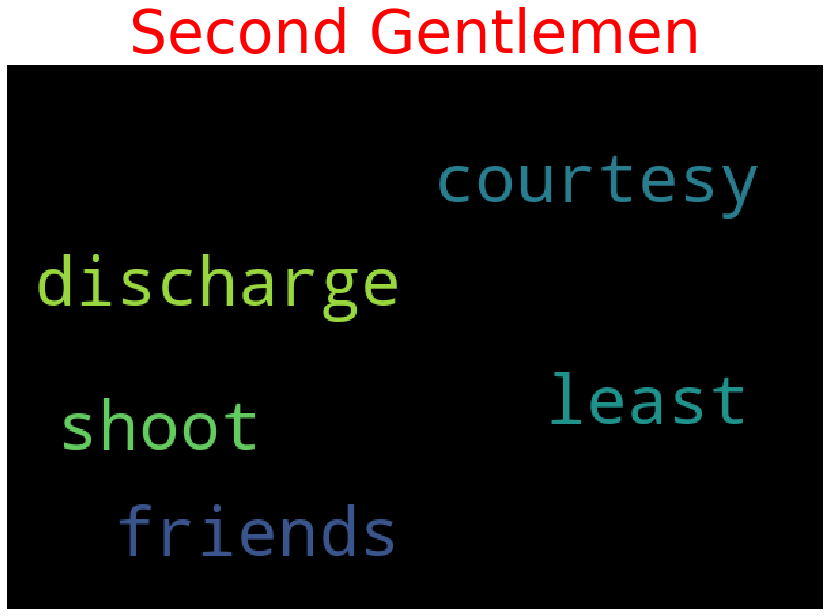

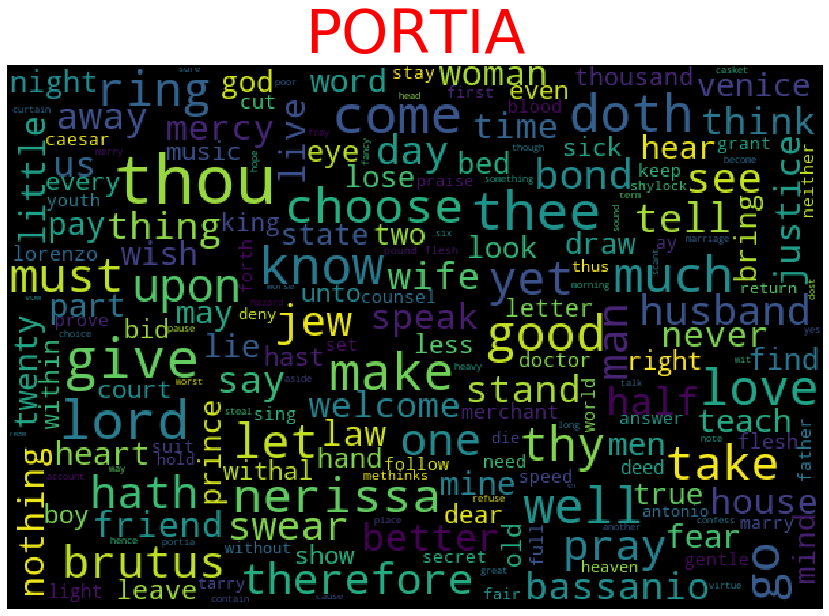

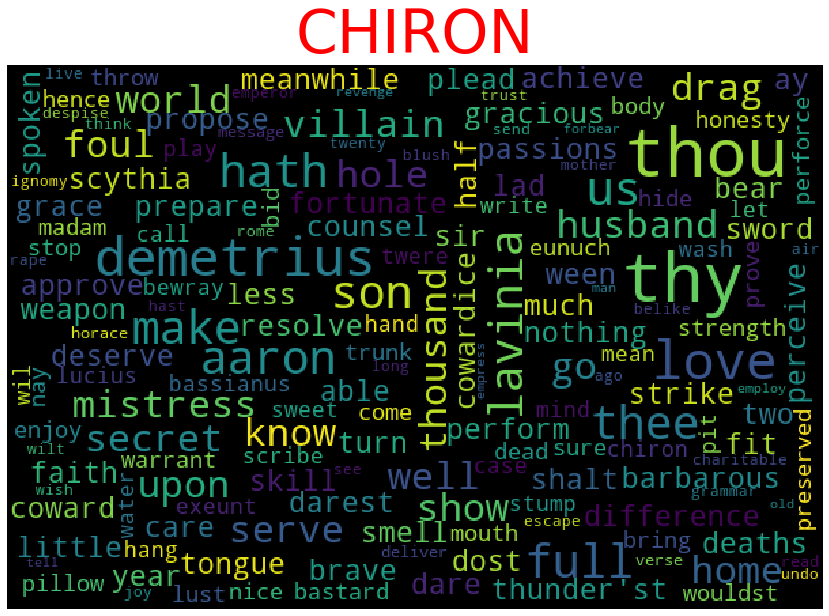

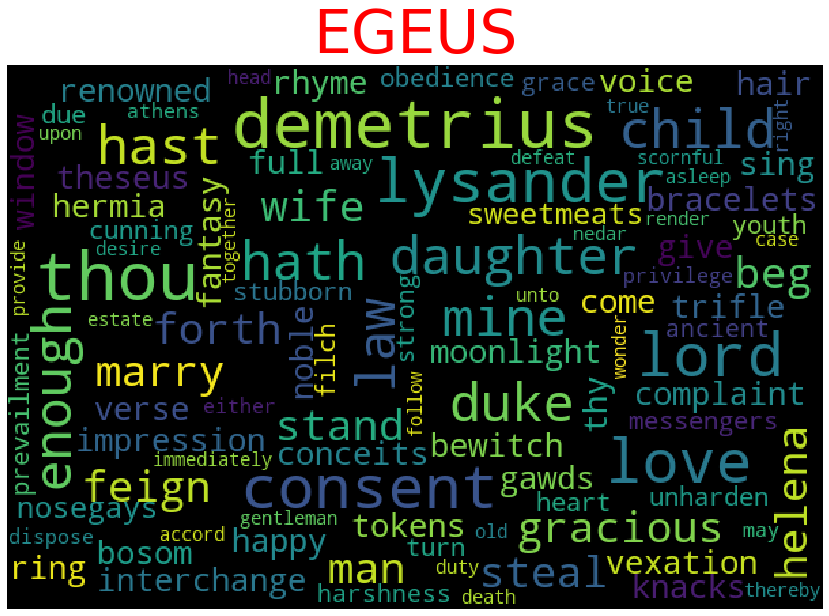

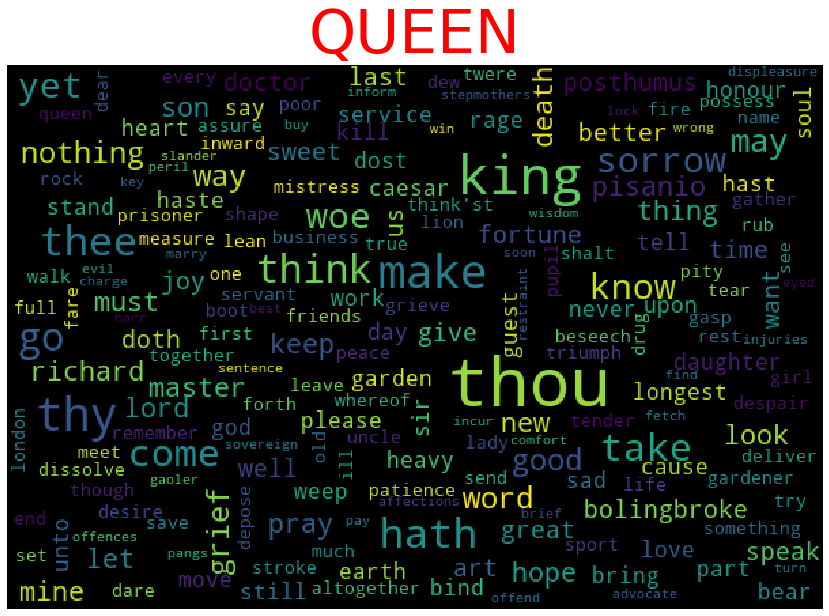

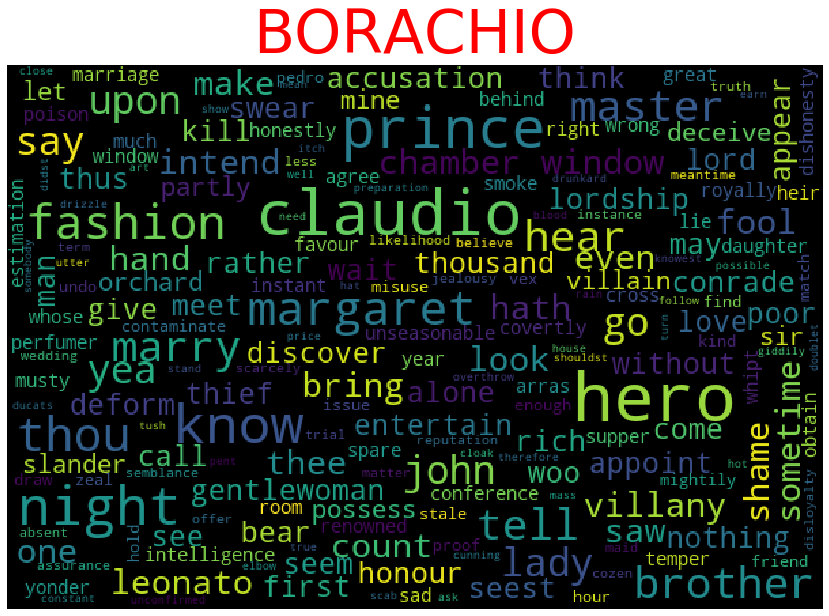

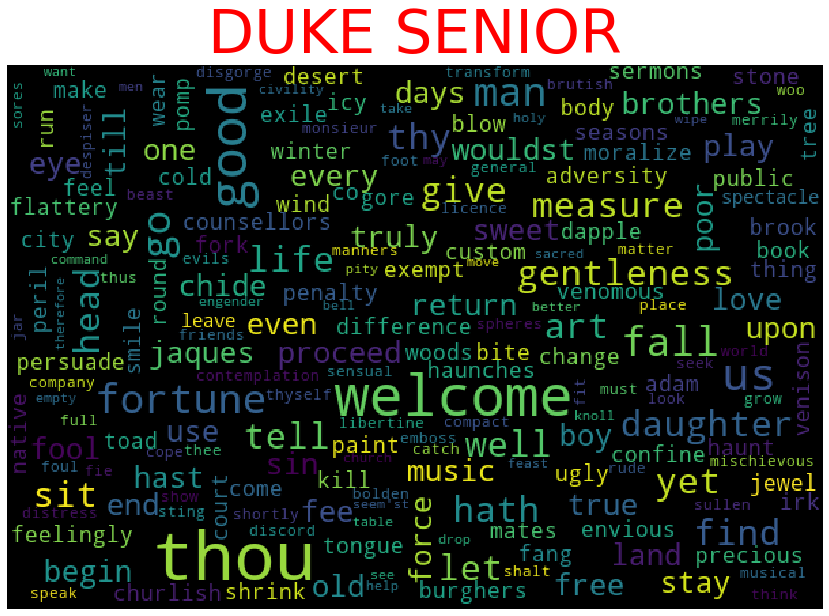

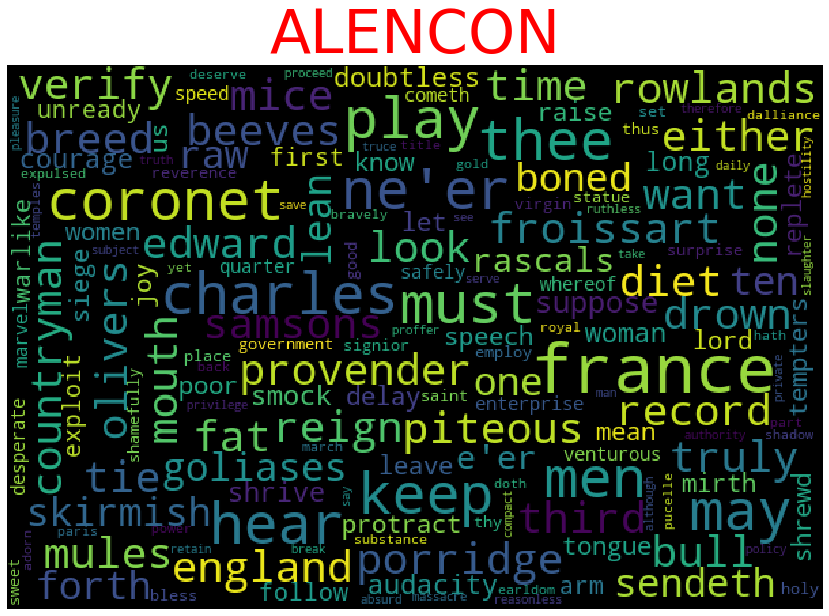

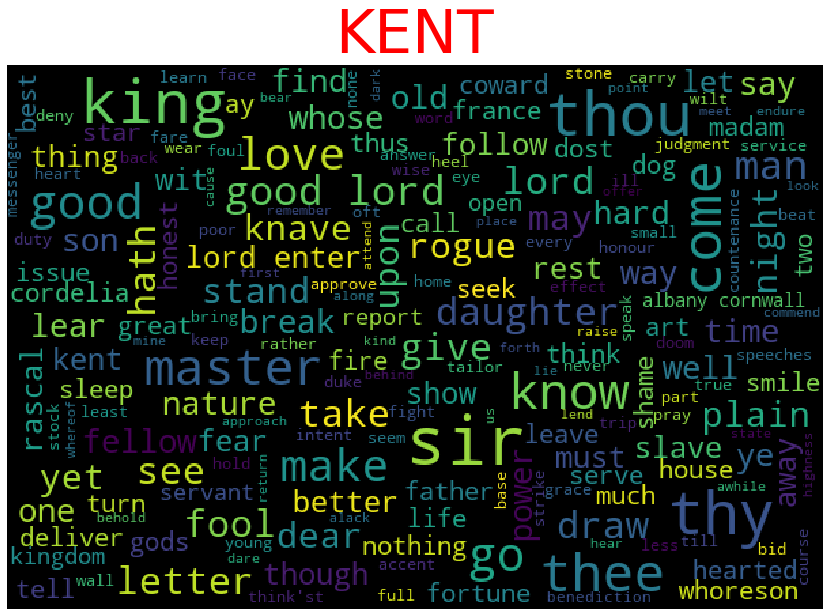

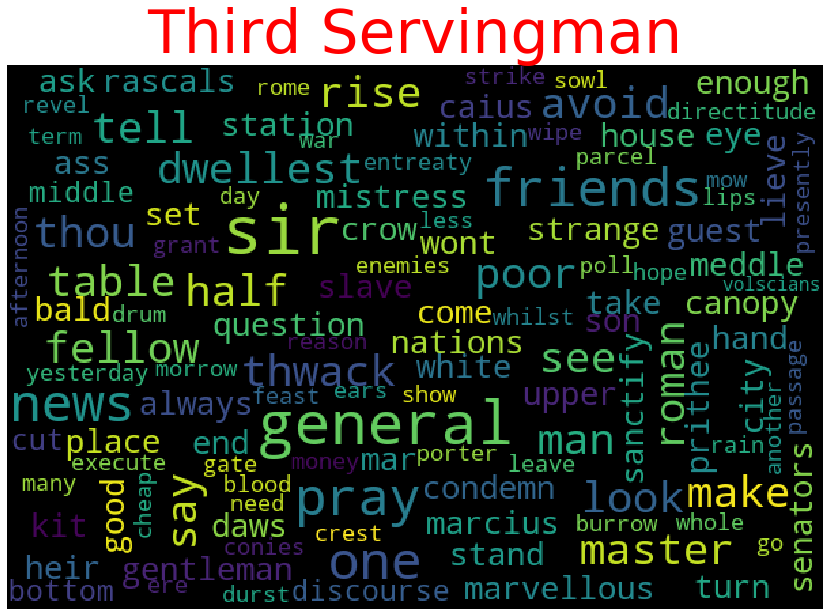

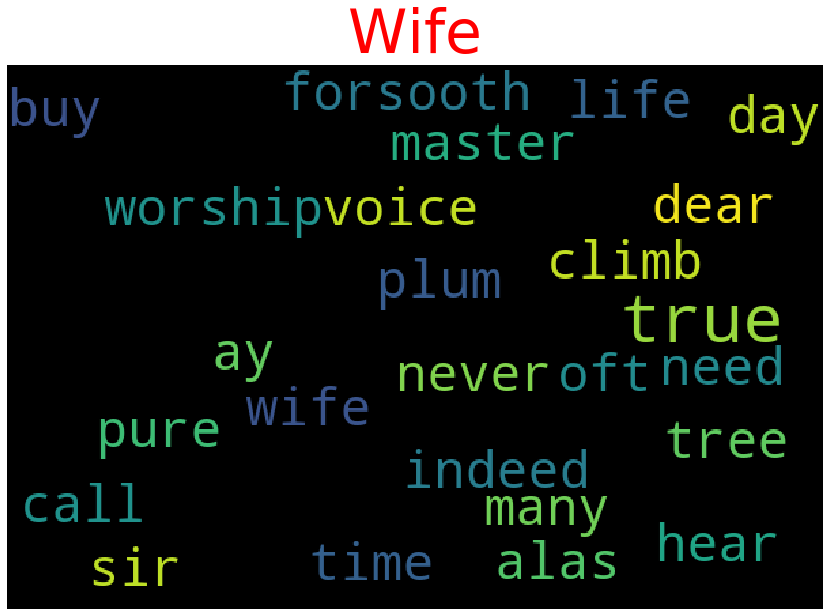

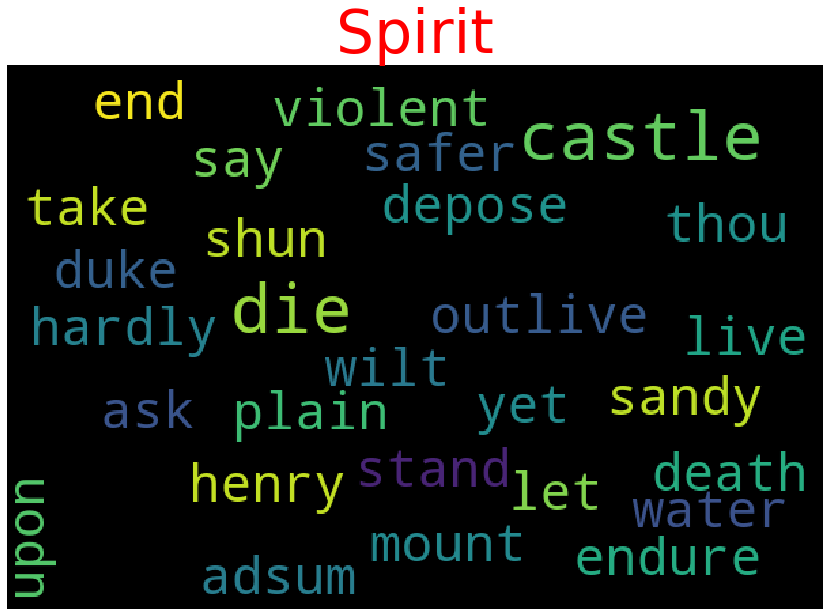

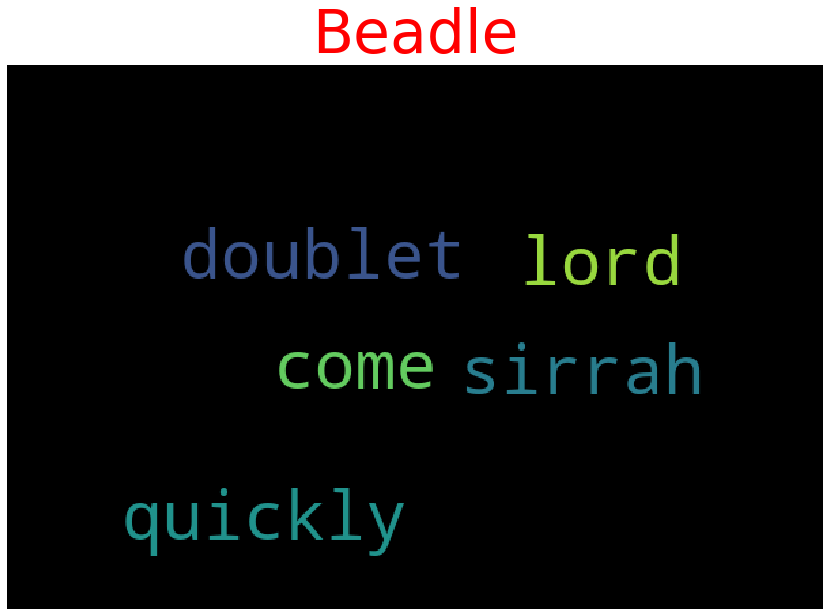

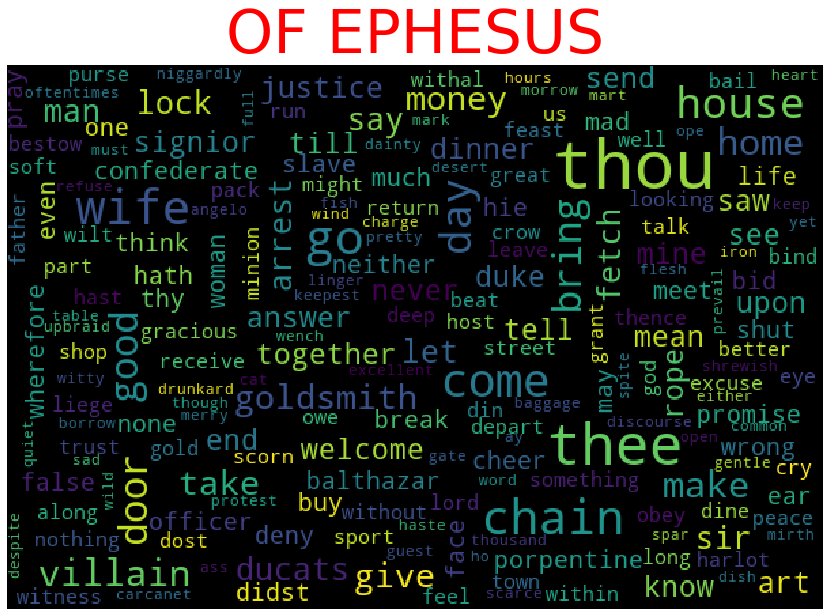

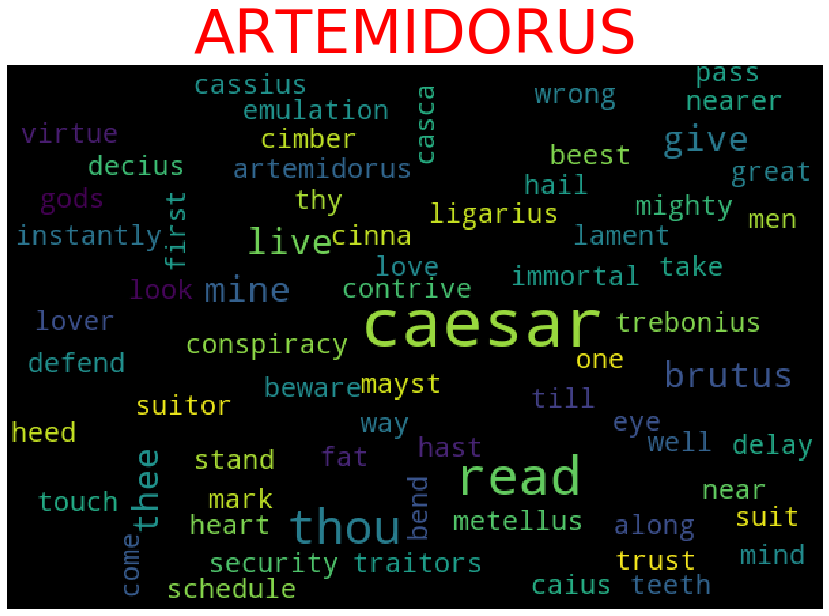

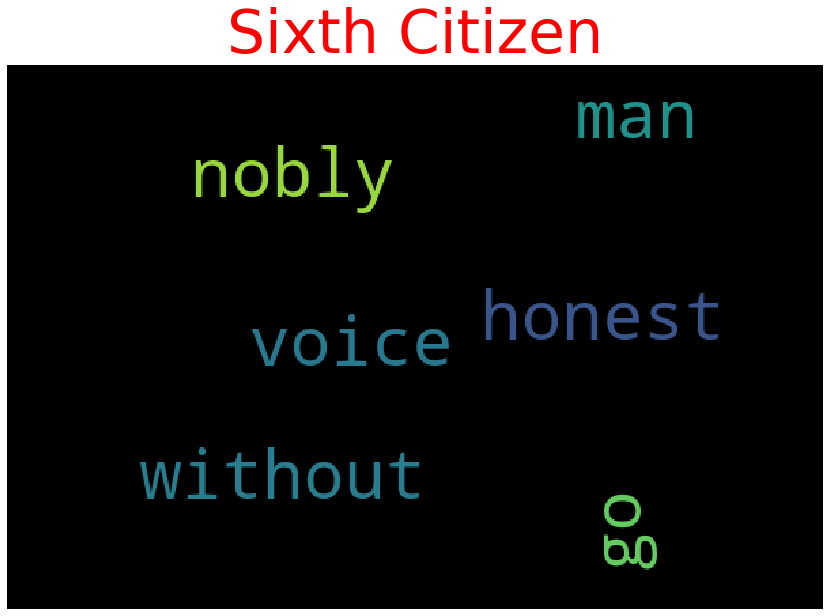

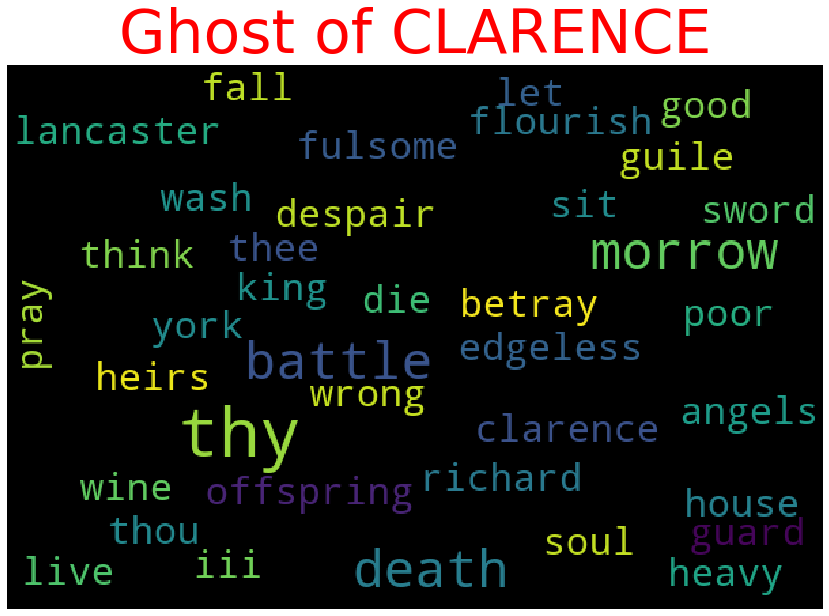

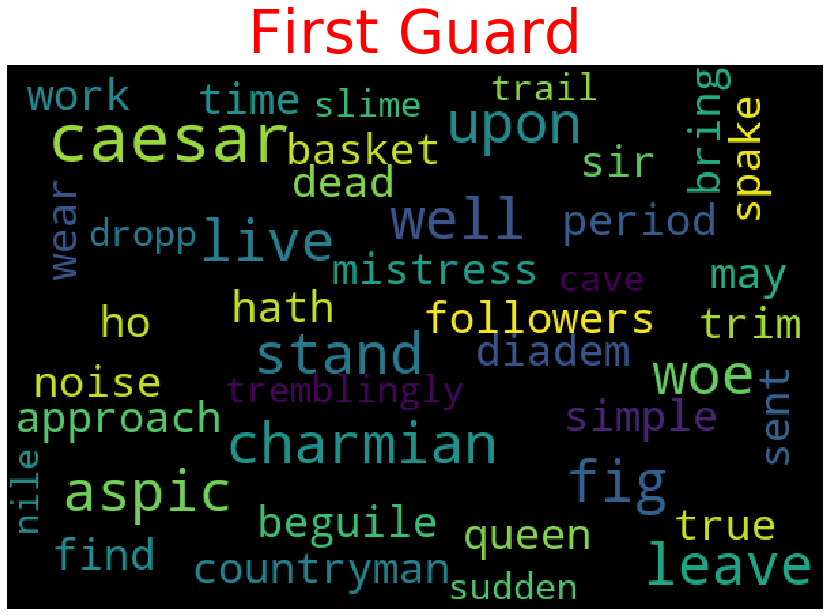

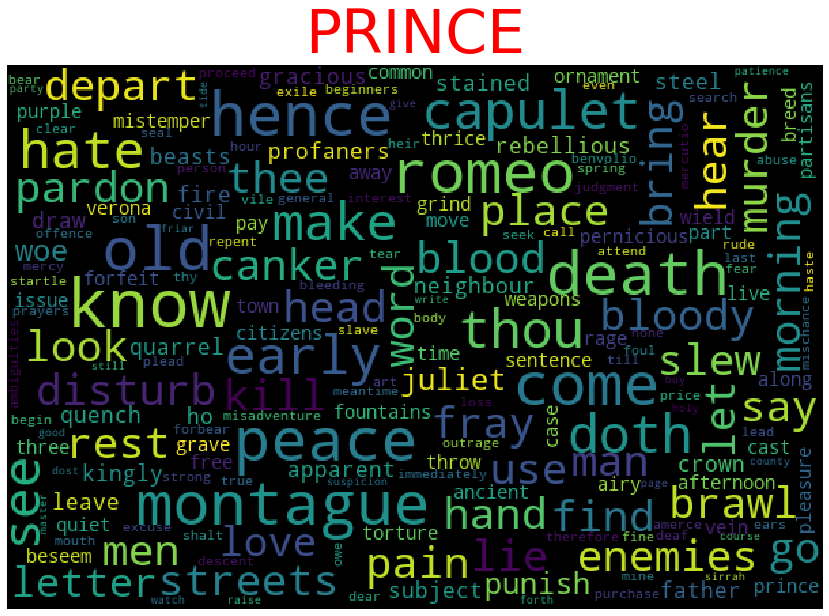

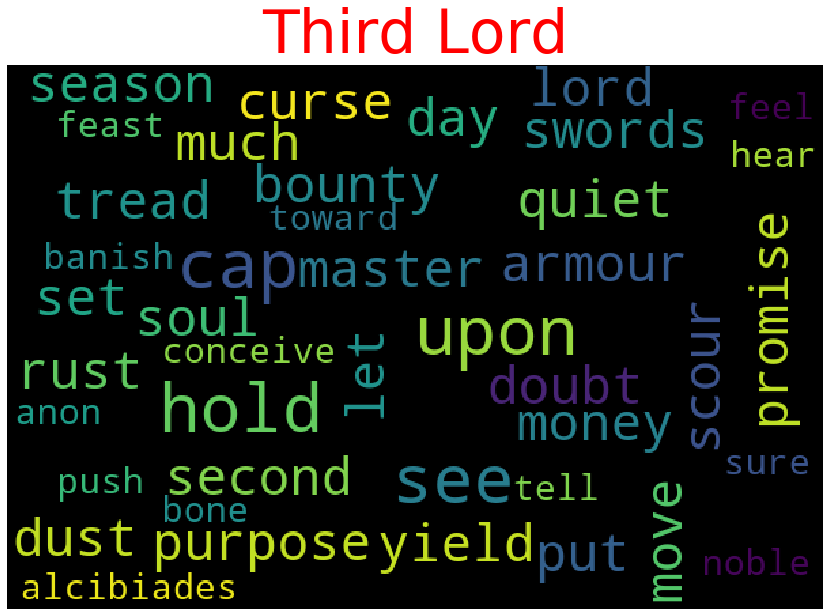

In [22]:

from wordcloud import WordCloud
def WordCloudGeneration(str1,title):
    plt.figure(figsize=(20, 10))

    wordcloudoflines = WordCloud( background_color='black',width=600, height=400, max_font_size=50).generate(str1)
    wordcloudoflines.recolor(random_state=0)
    plt.title(title, fontsize=60,color='red')
    plt.imshow(wordcloudoflines)
    plt.axis('off')
    plt.show()
    
for cols in data_play_content.sample(20).index:
    WordCloudGeneration(data_play_content.loc[cols,'Word_tokens'],cols)

### TF-IDF vectorization

Considering only the top 100 features across the corpus 

In [23]:
ngram_range = (1,2)
max_features = 100
min_df = 10
max_df = 20
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        lowercase=True,
                        norm='l2',
                        max_features=max_features,
                        max_df=max_df,
                        min_df=min_df,
                        sublinear_tf=True)
                        
featuers_labels = tfidf.fit_transform(data['PlayerLine']).toarray()


### Creating A data frame to fit into the model

In [24]:
f=pd.DataFrame(data=featuers_labels[0:,0:], index=[i for i in range(featuers_labels.shape[0])],columns=['f'+str(i) for i in range(featuers_labels.shape[1])])
f['Act'] = data['Act']
f['Scene'] = data['Scene']
f['SceneLine'] = data['SceneLine']
f['Play']=data['Play']
f = pd.get_dummies(f, columns=['Play'])
dftarget = pd.DataFrame(data, columns = [ 'Player'])

f.sample(10)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,Play_Richard III,Play_Romeo and Juliet,Play_Taming of the Shrew,Play_The Tempest,Play_Timon of Athens,Play_Titus Andronicus,Play_Troilus and Cressida,Play_Twelfth Night,Play_Two Gentlemen of Verona,Play_macbeth
98000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
20265,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
9516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
87076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
81772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
4849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
76121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
82296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
39086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
18565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


### Classification Using Various models

In [25]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(f, dftarget, test_size=0.2)


In [26]:
print(xtrain.shape, xtest.shape)

(84122, 139) (21031, 139)


In [27]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

model = GaussianNB()
dc = DecisionTreeClassifier()
rf = RandomForestClassifier()
model.fit(xtrain, ytrain)
dc.fit(xtrain, ytrain)
rf.fit(xtrain, ytrain)


/Users/sahithireddypaspuleti/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sahithireddypaspuleti/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/sahithireddypaspuleti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Accuracy Score with Naive Bayes, Decision Tree, Random Forest 

In [28]:
from sklearn.metrics import accuracy_score
print('Accuracy for GaussianNB: ', 100 * accuracy_score( ytest, model.predict(xtest)), '%')
print('Accuracy for Decision Tree: ', 100 * accuracy_score(ytest, dc.predict(xtest)), '%')
print('Accuracy for random forest: ', 100 * accuracy_score(ytest, rf.predict(xtest)), '%')

Accuracy for GaussianNB:  10.631924302220531 %
Accuracy for Decision Tree:  71.18063810565356 %
Accuracy for random forest:  71.06176596452856 %


### Classification using Nearest Neighbour Classifier

In [29]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(xtrain, ytrain)
print('Accuracy for nearest neighbour: ',100*accuracy_score(ytest, knn.predict(xtest)),'%')

/Users/sahithireddypaspuleti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


Accuracy for nearest neighbour:  42.75117683419714 %


### Let's see how the accuracy varies depending upon the max_depth of a decision tree

In [30]:
dc1 = DecisionTreeClassifier(max_depth=10)
dc2 = DecisionTreeClassifier(max_depth=25)
dc3 = DecisionTreeClassifier(max_depth=50)
dc4 = DecisionTreeClassifier(max_depth=100)
dc5 = DecisionTreeClassifier(max_depth=150)

dc1.fit(xtrain , ytrain)
dc2.fit(xtrain , ytrain)
dc3.fit(xtrain , ytrain)
dc4.fit(xtrain , ytrain)
dc5.fit(xtrain , ytrain)

print('Max Depth of 10 :', 100*accuracy_score(ytest, dc1.predict(xtest)), '%')
print(accuracy_score(ytest, dc2.predict(xtest)))
print(accuracy_score(ytest, dc3.predict(xtest)))
print(accuracy_score(ytest, dc4.predict(xtest)))
print(accuracy_score(ytest, dc5.predict(xtest)))

Max Depth of 10 : 15.829014312205791 %
0.4504303171508725
0.7114735390613856
0.7121392230516856
0.7121392230516856


# Notes

- Performed EDA on the dataset
- Splitted the ActSceneLine Feature into 3 seperate columns to fit the model
- Coverted the PlayerLine into different Vectors using TFIDF vectorization
- Used Play, Act ,Scene, SceneLine, Player line columns to classify the players.

# observations

- Accuracy is more with the Decision Tree and Random Forest Classification Models
- The accuracy in for this data set is varying with the maxdif and mindif of the TFIDF vectorization.
- Accuracy is also increasing with increase in the max_depth parameter of the DecisionTree Classifier and becomes constant after a certain depth